In [88]:
import os
from pathlib import Path
import numpy as np
import cv2
import matplotlib.pyplot as plt

from solarnet.datasets.utils import normalize

from solarnet.models import Segmenter

import torch

In [15]:
images = np.load('data/models/segmenter_images.npy')
images = np.moveaxis(images, 1, -1)

preds = np.load('data/models/segmenter_preds.npy')
true = np.load('data/models/segmenter_true.npy')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


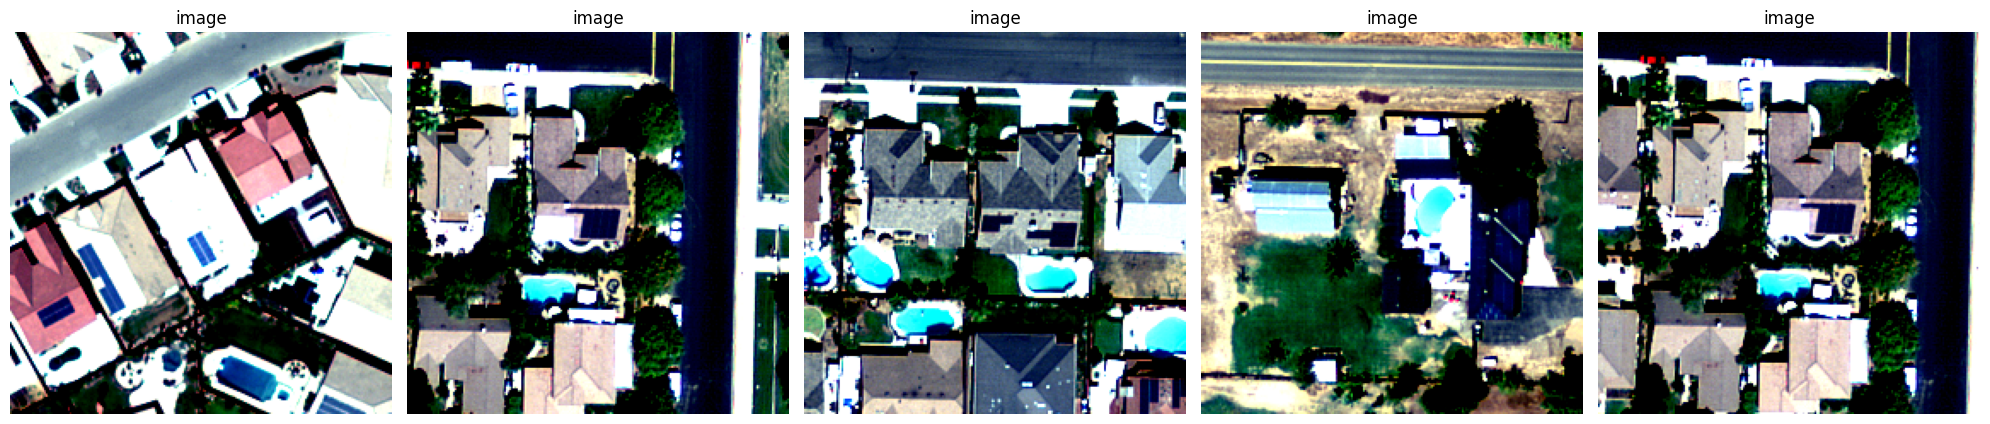

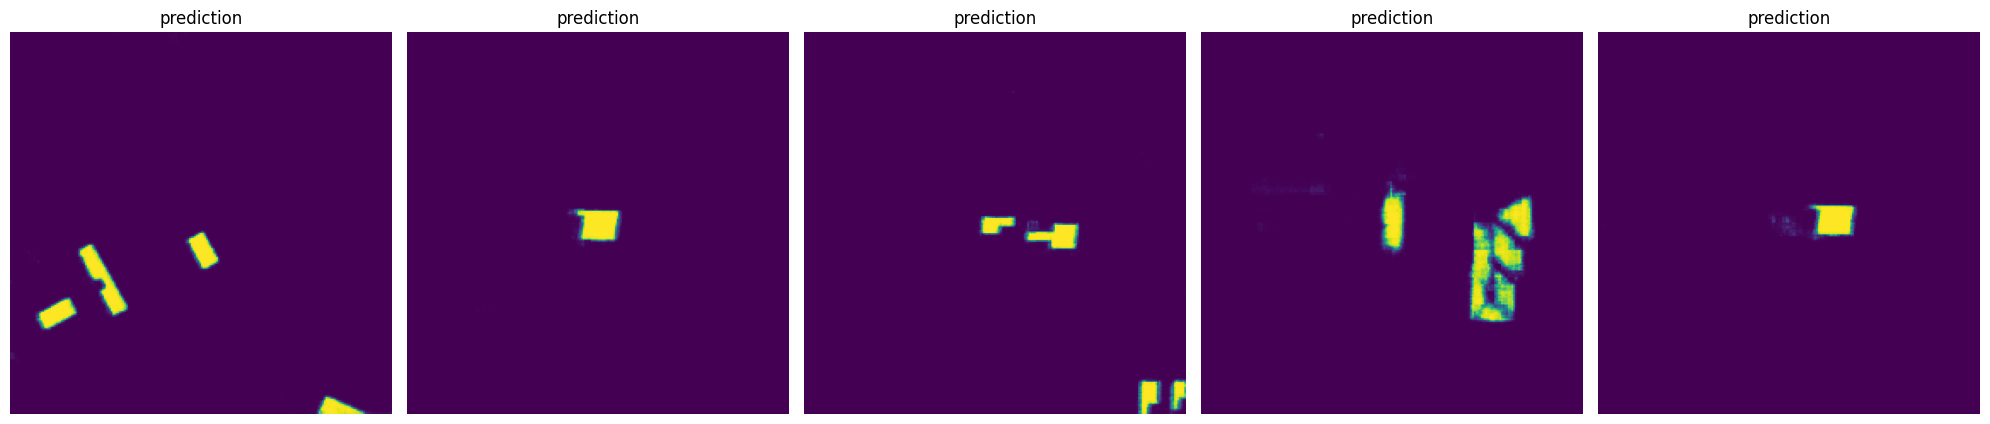

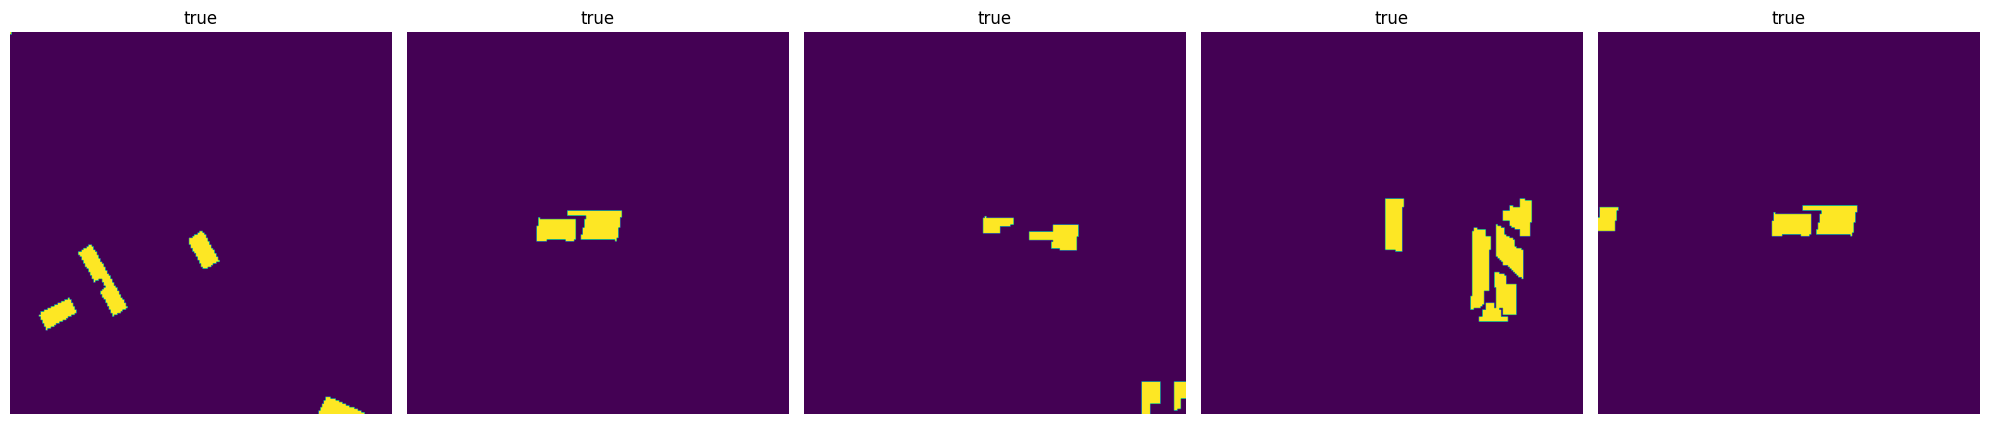

In [16]:
def plot_images(images, labels, n_images, figsize=(10, 5)):
    fig, axes = plt.subplots(nrows=1, ncols=n_images, figsize=figsize)
    for i, ax in enumerate(axes):
        ax.imshow(images[i])
        ax.set_title(labels[i])
        ax.axis('off')
    plt.tight_layout()
    plt.show()

plot_images(images=images, labels=['image']*5, n_images=5, figsize=(20, 10))
plot_images(images=preds, labels=['prediction']*5, n_images=5, figsize=(20, 10))
plot_images(images=true, labels=['true']*5, n_images=5, figsize=(20, 10))

In [18]:
images.shape

16768

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[[ 79  69  59 ...  65  61  72]
  [ 74  81  86 ...  67  61  71]
  [ 73  70  85 ...  61  63  58]
  ...
  [ 53  48  75 ...  48  55  47]
  [ 64  52 100 ...  49  50  51]
  [ 67  49  83 ...  45  47  56]]

 [[ 91  84  80 ...  82  80  83]
  [ 94  95  96 ...  79  77  81]
  [ 89  90 104 ...  74  72  71]
  ...
  [ 71  59  89 ...  55  63  76]
  [ 74  63 102 ...  56  60  77]
  [ 76  61  97 ...  60  61  73]]

 [[ 79  74  69 ...  72  70  72]
  [ 77  77  81 ...  70  68  66]
  [ 76  74  79 ...  67  67  70]
  ...
  [ 65  62  73 ...  58  62  63]
  [ 73  65  85 ...  61  61  62]
  [ 70  63  81 ...  62  63  69]]]
(3, 224, 224)


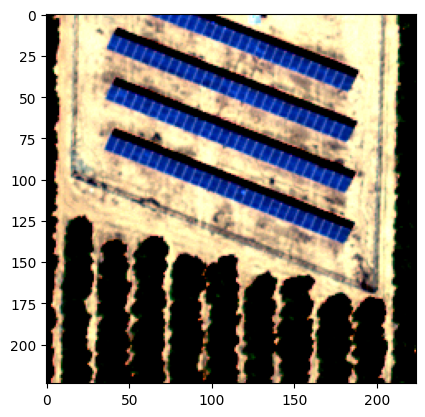

In [62]:
processed = 'data/processed/solar/org/Fresno_0.npy'
processed = np.load(processed)
print(processed)
print(processed.shape)
processed = normalize(processed)
processed = np.moveaxis(processed, 0, -1)
plt.imshow(processed)

In [ ]:
model = Segmenter()
model.load_state_dict(torch.load('data/models/segmenter.model', map_location=torch.device('cpu')))

model.eval()

In [116]:
# try some inference on the GIC dataset
gic_data_dir = Path('../Solar Panels Dataset - GeoTIFF/Solar Panels Dataset - GeoTIFF/')
resolution =0.075
image_size = 224

# show all files
for filename in os.listdir(gic_data_dir):
    if filename.endswith('.tiff'):
        image_path = gic_data_dir / filename
        gic_image = cv2.imread(str(image_path))
        gic_image = cv2.cvtColor(gic_image, cv2.COLOR_BGR2RGB)

        # Resize image to have resolution of 0.3 m/pixel
        gic_image = cv2.resize(gic_image, (0, 0), fx=1/4, fy=1/4)
        original_shape = gic_image.shape
        # Pad image to be divisible by 224
        top = 0
        bottom = 224 - gic_image.shape[0] % 224
        left = 0
        right = 224 - gic_image.shape[1] % 224
        gic_image = cv2.copyMakeBorder(gic_image, top, bottom, left, right, cv2.BORDER_REFLECT_101)
        
        # Crop image to squares
        predictions = []
        for offset_y in range(0, gic_image.shape[0], image_size):
            prediction_row = []
            for offset_x in range(0, gic_image.shape[1], image_size):
                gic_image_crop = gic_image[offset_y:offset_y+image_size, offset_x:offset_x+image_size, :]
                assert gic_image_crop.shape == (image_size, image_size, 3), 'Cropped image is not square'
                gic_image_crop = np.moveaxis(gic_image_crop, -1, 0)
                gic_image_crop = normalize(gic_image_crop)

                input_tensor = torch.as_tensor(gic_image_crop).unsqueeze(0).float()
                prediction = model(input_tensor)
                prediction_row.append(prediction.squeeze(0).squeeze(0))

            row = torch.cat(prediction_row, dim=1)
            # print('row.shape', row.shape)
            predictions.append(row)
        predictions = torch.cat(predictions, dim=0)
        # print('predictions.shape', predictions.shape)
        predictions = predictions[:original_shape[0], :original_shape[1]]
        predictions = predictions.detach().numpy() * 255
        predictions = cv2.resize(predictions, (0, 0), fx=4, fy=4)
        cv2.imwrite(str(gic_data_dir / filename.replace('.tiff', '_pred.png')), predictions)

In [123]:
for filename in os.listdir(gic_data_dir):
    if filename.endswith('_pred.png'):
        mask = cv2.imread(str(gic_data_dir / filename), cv2.IMREAD_GRAYSCALE)
        # mask = cv2.threshold(mask, 200, 255, cv2.THRESH_BINARY)[1]
        # print(mask.min(), mask.max())
        # break
        # map to color map
        mask = cv2.applyColorMap(mask, cv2.COLORMAP_JET)
        cv2.imwrite(str(gic_data_dir / filename.replace('_pred.png', '_pred_color.png')), mask)